In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [2]:
# Finds largest contour within bounding box
def findROIContour(thresh, bbox):
    bbox = map(int, bbox)
    x, y, w, h = bbox
    # ROI based off bounding box coordinates
    thresh_roi = thresh[y:y+h, x:x+w]
    # Mask of black pixels so only ROI is searched for contour
    mask = np.zeros((thresh.shape[0], thresh.shape[1]), np.uint8)
    mask[y:y+h, x:x+w] = thresh_roi
    
    # Taken from: https://stackoverflow.com/questions/54615166/find-the-biggest-contour-opencv-python-getting-errors
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours[0]]
    # If no contour, return None
    #print(contour_areas)
    if contour_areas is None or len(contour_areas)==0:
        final_c = [None, None]
    else:
        final_c = max(contour_areas, key=lambda x: x[0]) # Find largest contour in box
    return final_c[1]

# Find Centre coordinates of contour
def getContourMoment(contour):
    m = cv2.moments(contour)
    # Find Contour centre 
    x = m['m10'] / m['m00']
    y = m['m01'] / m['m00']
    return int(x), int(y) 

# Finds the full contour based on bounding box ROI
def findFullContour(thresh, centre):
    x, y = centre
    # Find all contours in image
    contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # Return contour that centre belongs to
    for c in contours[0]:
        dist = cv2.pointPolygonTest(c, (x,y), False)
        if dist == 1.0:
            final_contour = c
            #print('Contour Found')
            #if cv2.contourArea(c) > size * 1.5:
            #    pass
            break
        else:
            final_contour = findROIContour(thresh, (x-10, y-10, 20, 20))
    #print(final_contour)
    return final_contour

# Fits a bounding box tightly around the contour
def getFittedBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return rect, box

# Converts a fitted bounding box to a straight one with no rotation 
def rotatedBoxConverter(box):
    box_t = np.array(box).T
    x, y = min(box_t[0]), min(box_t[1])
    w, h = max(box_t[0]) - x, max(box_t[1]) - y
    return x, y, w, h

# Calculate avg area of box
def avgArea(box, total, count):
    x, y, w, h = box
    total += w * h
    avg = total / count
    return total, avg




### Remove Duplicates

In [3]:
waggle_df = pd.read_pickle('WaggleDetections-Bees10.pkl')
#waggle_df.drop(['index'], axis=1, inplace=True)
#waggle_df.reset_index(inplace=True)
# Sort by cluster and then frame so the dataset is ordered in blocks of clusters
waggle_df = waggle_df.sort_values(by=['Cluster', 'frame']).reset_index().drop(['index'], axis=1).reset_index()

In [4]:
waggle_df[waggle_df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
81,81,1087,569,60,213.5,"[[[1074, 561]], [[1074, 562]], [[1074, 563]], ...",2
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
84,84,1080,544,63,197.0,"[[[1069, 533]], [[1070, 534]], [[1070, 535]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
86,86,1072,547,71,283.5,"[[[1065, 527]], [[1064, 528]], [[1063, 528]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
89,89,1075,539,79,267.0,"[[[1042, 521]], [[1042, 522]], [[1043, 523]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2


In [5]:
# All rows duplicated on frame and cluster
dup = waggle_df[waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster
dup

# All non duplicated rows
non_dup = waggle_df[~waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster

In [6]:
dup

,index,x,y,frame,size,contour,Cluster
1,1,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
2,2,1041,250,2,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
8,8,1037,247,9,358.5,"[[[1052, 226]], [[1051, 227]], [[1050, 227]], ...",0
9,9,1075,243,9,689.5,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0
10,10,1075,254,10,627.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0
...,...,...,...,...,...,...,...
14439,14439,1205,483,13598,274.0,"[[[1214, 467]], [[1213, 468]], [[1212, 468]], ...",511
14443,14443,1227,500,13603,328.5,"[[[1218, 473]], [[1219, 474]], [[1220, 475]], ...",511
14444,14444,1199,492,13603,213.5,"[[[1196, 467]], [[1195, 468]], [[1194, 469]], ...",511
14448,14448,1227,513,13611,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",511


In [7]:
a = dup.index.values
b = dup.index.values - 1 # Rows before duplicate
c = dup.index.values + 1 # Rows after duplicate

# Concatenate removing duplicate indices
idx = np.unique(np.concatenate((a, b, c)))

df = waggle_df[waggle_df.index.isin(idx)]
df['Cluster'].value_counts()

302    116
503     89
511     85
461     78
181     77
      ... 
348      1
428      1
418      1
372      1
206      1
Name: Cluster, Length: 392, dtype: int64

In [8]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
84,84,1080,544,63,197.0,"[[[1069, 533]], [[1070, 534]], [[1070, 535]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
89,89,1075,539,79,267.0,"[[[1042, 521]], [[1042, 522]], [[1043, 523]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2


In [9]:
pts = df[['index', 'x','y','frame']].values

#pts = pts[np.argsort(pts[:, -1], axis = 0)]    # to sort about last column if not sorted
# Returns indices of duplicates
same_pts = [np.argwhere(i[0] == pts[:, -1]) for i in np.array(np.unique(pts[:, -1], return_counts=True)).T if i[1]>=2]
remove_row = []
for i in same_pts:
    dist = []
    pre = min(i)-1
    post = max(i)+1
    for j in i:
        # Euclidean distance from duplicate points and the point in the frame before and after 
        dist_pre = np.sqrt((pts[pre, 1]-pts[j, 1])**2 + (pts[pre, 2]-pts[j, 2])**2)
        dist_post = np.sqrt((pts[post, 1]-pts[j, 1])**2 + (pts[post, 2]-pts[j, 2])**2)
        dist.append(dist_pre + dist_post)
    remove_row.append(i[np.argmax(dist)][0])
# Returns pts with furthest duplicates removed
final_pts = np.delete(pts, remove_row, axis = 0)

In [10]:
# Concatenate final_pts index with non_duplicate index, removing unique values
final_idx = np.unique(np.concatenate((non_dup.index.values, final_pts[:, 0])))

In [11]:
df = waggle_df[waggle_df['index'].isin(final_idx)]

In [12]:
df['Cluster'].value_counts()
#df[df['Cluster']==229]

302    97
181    82
511    79
296    77
461    71
       ..
140     9
125     9
399     9
250     9
477     8
Name: Cluster, Length: 512, dtype: int64

In [13]:
df[df['Cluster']==2]

,index,x,y,frame,size,contour,Cluster
81,81,1087,569,60,213.5,"[[[1074, 561]], [[1074, 562]], [[1074, 563]], ...",2
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
86,86,1072,547,71,283.5,"[[[1065, 527]], [[1064, 528]], [[1063, 528]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2
91,91,1078,540,83,582.5,"[[[1057, 505]], [[1056, 506]], [[1055, 506]], ...",2
92,92,1079,569,86,203.0,"[[[1073, 562]], [[1072, 563]], [[1071, 563]], ...",2


### Fill Missing

In [18]:
# Prevent tracking update failures
def anchorBox(box, prev_box, avg):
    global counter
    x0, y0, w0, h0 = prev_box
    x, y, w, h = box
    
    # If bounding box is too far from previous box
    #if abs(x - x0) > w0/2 and abs(y - y0) > h0/2:
    if abs(x - x0) > w0/1.5 or abs(y - y0) > h0/1.5: # CHANGED FOR TESTING ON BEES10 2
        print('Box Lost')
        success = False
    # If bounding box is too large
    elif abs(w * h) > (avg * 2):
        print('Box Lost (Expanded)')
        print(str(counter))
        success = 'Expanded'
    # If bounding box is too small
    elif abs(w * h) < (avg / 1.5):
        print('Box Lost (Shrunk)')
        print(str(counter))
        success = 'Shrunk'
    # prev_box only updated if box found
    else:
        print('Box Found')
        prev_box = box 
        success = True

    return success, prev_box

def expandBox(img, bbox):
    contour = None
    x, y, w, h = bbox
    x -= 10
    w += 20
    y -= 10
    h += 20
    bbox = (x, y, w, h)
    print(bbox)
    contour = findROIContour(img, bbox)
    return bbox, contour

# Find which way object is facing by the direction in which bounding box moves, to be coupled with angle of bounding rect
def moveDirection(prev_bbox, bbox):
    x, y, w, h = bbox
    x0, y0, w0, h0 = prev_bbox
    
    xd = x - x0
    # if xd is negative, moved west, if xd is positive, moved east
    yd = y - y0
    # if yd is negative, moved north, if yd is positive, moved south
    movement = (xd, yd)
    return movement

In [15]:
final_df = pd.DataFrame(columns=['x', 'y', 'frame', 'bbox', 'size', 'angle', 'cluster']) # maybe add direction change?

,index,x,y,frame,size,contour,Cluster
2095,2095,1179,333,1406,329.5,"[[[1189, 308]], [[1188, 309]], [[1187, 309]], ...",75
2096,2096,1201,344,1409,295.5,"[[[1209, 319]], [[1209, 320]], [[1209, 321]], ...",75
2097,2097,1183,321,1409,250.0,"[[[1190, 306]], [[1189, 307]], [[1188, 307]], ...",75
2098,2098,1202,344,1415,247.0,"[[[1180, 332]], [[1180, 333]], [[1180, 334]], ...",75
2101,2101,1197,321,1416,638.0,"[[[1213, 309]], [[1212, 310]], [[1211, 310]], ...",75
2102,2102,1199,328,1417,728.5,"[[[1213, 309]], [[1212, 310]], [[1211, 310]], ...",75
2103,2103,1200,322,1421,450.5,"[[[1219, 304]], [[1218, 305]], [[1217, 305]], ...",75
2104,2104,1221,338,1422,202.0,"[[[1222, 329]], [[1221, 330]], [[1221, 331]], ...",75
2105,2105,1206,312,1422,467.5,"[[[1220, 292]], [[1221, 292]], [[1222, 293]], ...",75
2107,2107,1203,317,1423,453.0,"[[[1206, 290]], [[1207, 290]], [[1208, 290]], ...",75


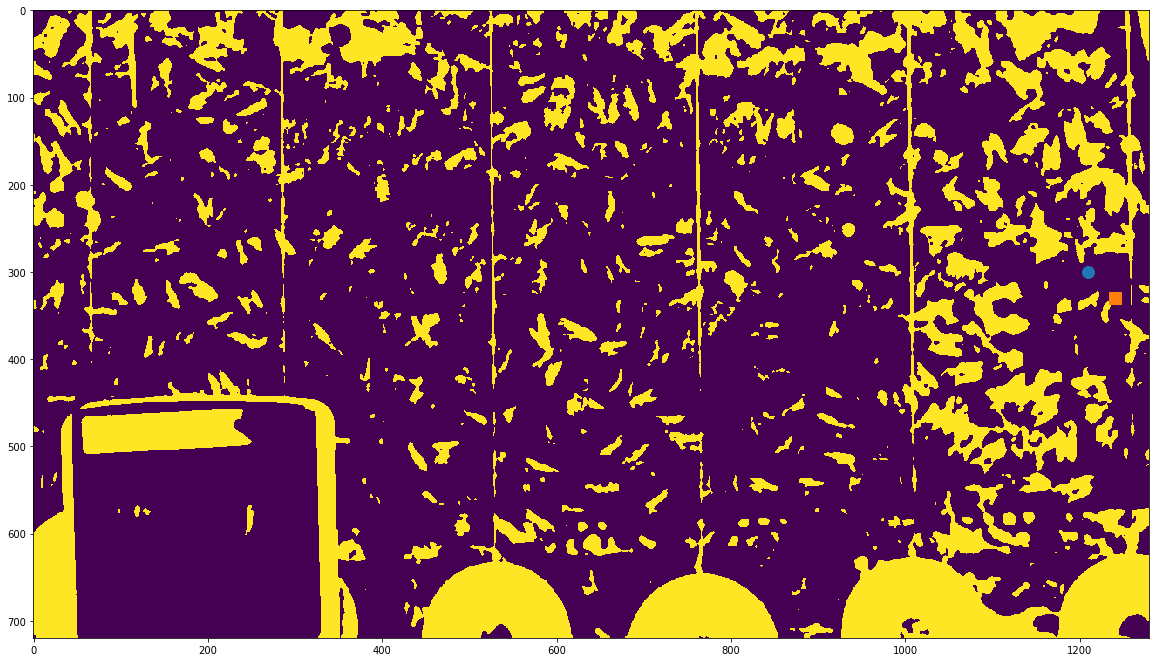

In [16]:
clust = df[df['Cluster']==75] # 1, 6, 35, 72 (didn't work, also not a waggle)
clust
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, 233)
_, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(20,20))
plt.imshow(thresh)
plt.plot(1225-15, 315-15, marker='o', markersize=12)
plt.plot(1225+15, 315+15, marker='s', markersize=12)
clust

[[[1175  318]]

 [[1174  319]]

 [[1174  320]]

 [[1173  321]]

 [[1172  322]]

 [[1171  322]]

 [[1171  323]]

 [[1172  323]]

 [[1173  323]]

 [[1174  323]]

 [[1175  323]]

 [[1176  323]]

 [[1177  324]]

 [[1177  325]]

 [[1176  326]]

 [[1176  327]]

 [[1176  328]]

 [[1176  329]]

 [[1177  329]]

 [[1178  329]]

 [[1179  329]]

 [[1180  330]]

 [[1181  331]]

 [[1181  332]]

 [[1182  333]]

 [[1182  334]]

 [[1182  335]]

 [[1182  336]]

 [[1182  337]]

 [[1182  338]]

 [[1181  339]]

 [[1180  340]]

 [[1179  340]]

 [[1178  340]]

 [[1177  341]]

 [[1176  342]]

 [[1176  343]]

 [[1176  344]]

 [[1175  345]]

 [[1175  346]]

 [[1175  347]]

 [[1176  347]]

 [[1177  347]]

 [[1178  347]]

 [[1179  347]]

 [[1180  347]]

 [[1181  347]]

 [[1182  347]]

 [[1183  347]]

 [[1184  347]]

 [[1185  347]]

 [[1186  347]]

 [[1187  347]]

 [[1188  347]]

 [[1189  347]]

 [[1190  347]]

 [[1191  347]]

 [[1192  347]]

 [[1193  347]]

 [[1193  346]]

 [[1193  345]]

 [[1193  344]]

 [[1193 

-1

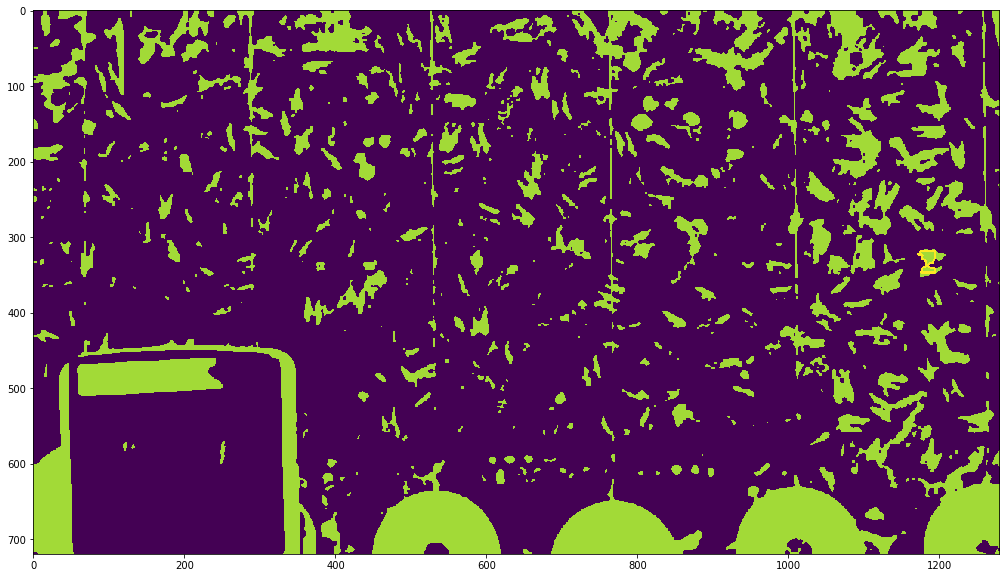

In [20]:
start = clust.iloc[0, :]['frame']
end = clust.iloc[-1, :]['frame']
cluster = clust.iloc[0, :]['Cluster']
# Get range of frames where waggle occurs
rang = np.arange(start, end, 1)
missing = list(set(rang)-set(clust.frame.values)) # Frames where waggle missing from df

counter = start
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, start)
ret, frame = cap.read()
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)

# Find contour bounding box
x, y = clust.iloc[0, :]['x'], clust.iloc[0]['y']
bbox = x-15, y-15, 30, 30

contour = findROIContour(opening, bbox)
print(contour)
if contour is None:
    print('Contour None')
    contour = findROIContour(thresh, bbox)
    opening = thresh # For findFullContour
plt.figure(figsize=(20,10))
cv2.drawContours(opening, contour, -1, (255,0,0), 2, 1)
plt.imshow(opening)
centre = getContourMoment(contour)
contour = findFullContour(opening, centre)
if cv2.contourArea(contour) > clust['size'].max():
    contour = findROIContour(opening, bbox)
    print(contour)
rect, box = getFittedBox(contour)
bbox = rotatedBoxConverter(box)
prev_bbox = bbox
avg = bbox[2]*bbox[3]
total = avg
print(avg)

# Create tracker 
print(frame)
tracker = cv2.TrackerCSRT_create()
tracker.init(frame, bbox)

rois = []

while counter < end:
    counter += 1 
    print(counter)
    ret, frame = cap.read()
    
    # Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (15,15), 1)
    thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = cv2.erode(opening, kernel, iterations=1)

    # If frame not in df, use tracker to fill in the missing
    if counter in missing:
        print('Missing')
        bbox = prev_bbox[0] - 10, prev_bbox[1] - 10, prev_bbox[2] + 20, prev_bbox[3] + 20
#         # update tracker
#         ret, bbox = tracker.update(frame)
#         print(bbox)
#         # Prevent tracking errors
#         found, prev_bbox = anchorBox(bbox, prev_bbox, avg)
# #         if found is 'Shrunk':
# #             print('Box Shrunk')
# #             bbox, contour = expandBox(opening, bbox)
#         if found is False:
#             print('False')
#             bbox = prev_bbox[0] - 5, prev_bbox[1] - 5, prev_bbox[2] + 10, prev_bbox[3] + 10
#             print(bbox)
#             #break
    
    # If frame is in df, use df coordinates
    else:
        print('In DF')
        waggle = clust[clust['frame']==counter].reset_index()
        x, y = waggle.loc[0, 'x'], waggle.loc[0, 'y']
        bbox = x-15, y-15, 30, 30
    
    # If bbox goes out of frame, end tracking 
    if bbox[0] < 0 or bbox[0] > width or bbox[1] < 0 or bbox[1] > height:
        print('Object out of bounds')
        final_df.loc[len(final_df)] = 0
        break        
    
    # Use to anchor the box
    if found is not True:
        pass
    
    # Find contour from bbox and get information
    print(bbox)
    contour = findROIContour(opening, bbox)
    if contour is None:
        print('Contour None')
        contour = findROIContour(thresh, bbox)
        opening = thresh # For findFullContour
    # If contour still None, dilate
    i = 0
    while contour is None or cv2.contourArea(contour) <= 80: # or too small
        print('Contour still none')
        dilate = cv2.dilate(opening, kernel, iterations=1)
        contour = findROIContour(dilate, bbox)
        opening = dilate # For findFullContour
        i += 1
        if i > 40:
            break
    roi_contour = contour # Save for use in findFullContour failure
    # Readjust centre and find full contour outside ROI
    centre = getContourMoment(contour)
    contour = findFullContour(opening, centre)
    # If contour too large, erode image, then use ROI
    while cv2.contourArea(contour) > clust['size'].max():
        opening = cv2.erode(opening, kernel, iterations = 1)
        bbox = centre[0]-15, centre[1]-15, 30, 30
        contour = findROIContour(opening, bbox)
        if contour is None:
            contour = roi_contour
            break
    rect, box = getFittedBox(contour)
    bbox = rotatedBoxConverter(box)
    if bbox[2]*bbox[3] > avg*1.5:
        print('Too Large')
        # Re-centre ROI to contour, and get bbox on cropped contour
        x, y = centre 
        bbox = x-15, y-15, 30, 30
        contour = findROIContour(opening, bbox)
        rect, box = getFittedBox(contour)
        print(rect[-1])
        bbox = rotatedBoxConverter(box)
    
    angle = rect[-1]
    size = cv2.contourArea(contour)
    
    # If next frame is missing data, initialise tracker on bounding box
    if counter not in missing and counter + 1 in missing:
        print('c')
        # find contour
        tracker = cv2.TrackerCSRT_create()
        tracker.init(frame, bbox)
        
    print(bbox)
    # VISUALS    
    if ret:
    # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
        cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    cv2.imshow("Tracking", frame)
    cv2.imshow("Threshold", opening)
    cv2.waitKey(100)
    if found is not True:
        if cv2.waitKey(0) & 0xFF == ord('c'):
            continue
    
    final_df.loc[len(final_df)] = [centre[0], centre[1], counter, box, size, angle, cluster]
    
    movement = moveDirection(prev_bbox, bbox) # Track direction of box movement
    prev_bbox = bbox
    total, avg = avgArea(bbox, total, (counter-start)) # Track avg size of bounding box

    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

array([[  0,   0,   0, ..., 220, 220, 220],
       [  0,   0,   0, ..., 220, 220, 220],
       [  0,   0,   0, ..., 220, 220, 220],
       ...,
       [  0,   0,   0, ...,   0,   0, 220],
       [  0,   0,   0, ...,   0,   0, 220],
       [  0,   0,   0, ...,   0,   0, 220]], dtype=uint8)

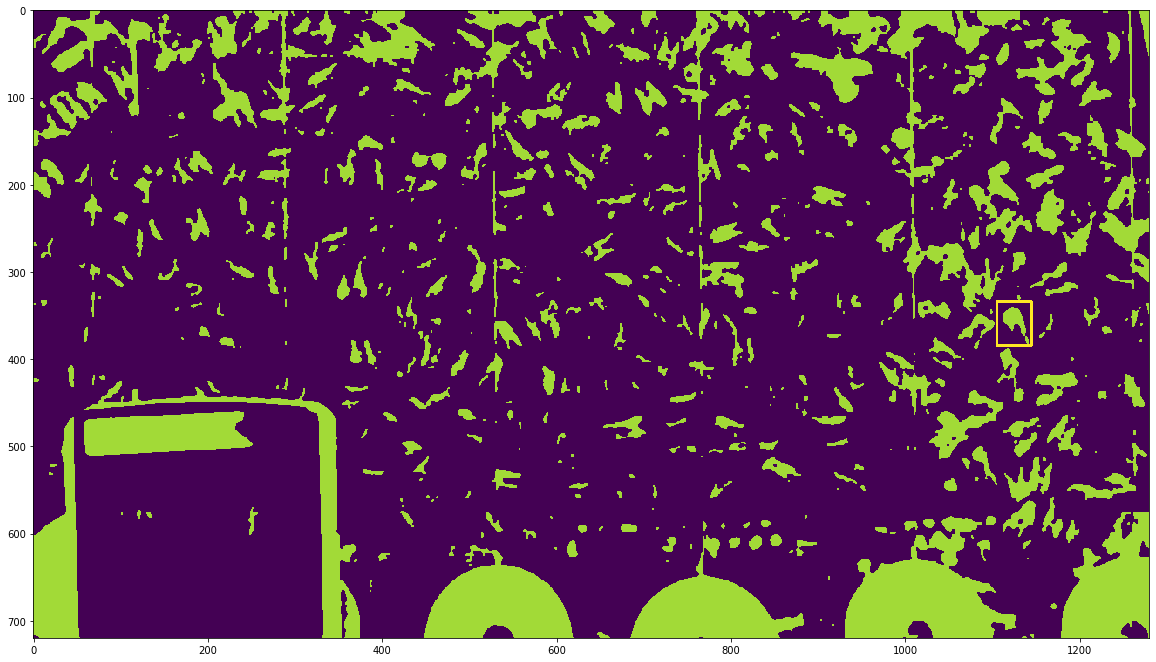

In [28]:
plt.figure(figsize=(20,20))
plt.imshow(opening)
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)

In [88]:
final_df[final_df['cluster']==72]

,x,y,frame,bbox,size,angle,cluster
989,1188,303,3050,"[[1202, 317], [1173, 317], [1173, 288], [1202,...",841.0,-90.000000,72
990,1171,304,3051,"[[1158, 315], [1155, 289], [1173, 287], [1176,...",209.0,-6.340192,72
991,1159,283,3052,"[[1171, 297], [1144, 297], [1144, 268], [1171,...",361.0,-90.000000,72
992,1155,272,3053,"[[1169, 286], [1140, 286], [1140, 257], [1169,...",483.0,-90.000000,72
993,1184,315,3054,"[[1191, 320], [1179, 320], [1179, 311], [1191,...",86.5,-90.000000,72
...,...,...,...,...,...,...,...
1071,1239,313,3132,"[[1251, 327], [1234, 324], [1237, 300], [1254,...",284.5,-82.405357,72
1072,1244,302,3133,"[[1247, 314], [1232, 295], [1239, 289], [1255,...",123.5,-38.157227,72
1073,1241,287,3134,"[[1250, 296], [1231, 296], [1231, 277], [1250,...",234.0,-90.000000,72
1074,1240,276,3135,"[[1254, 290], [1225, 290], [1225, 261], [1254,...",691.5,-90.000000,72


In [ ]:
from math import cos, sin
cols = (len(final_df['bbox']) // 10) + 1
plt.figure(figsize=(40, 20))

for i in range(0, len(final_df['bbox'])):
    x = [final_df.loc[i, 'bbox'][0][0], final_df.loc[i, 'bbox'][1][0]]
    y = [final_df.loc[i, 'bbox'][0][1], final_df.loc[i, 'bbox'][1][1]]
    
    angle = final_df.loc[i, 'angle']
    x, y = final_df.loc[i, 'bbox'][0]
    x1, y1 = x + 50 * cos(angle), y + 50 * sin(angle)


    # Setting the values for all axes.
    plt.subplot(cols, 10, i+1)
    plt.plot((x, x1), (y, y1), linewidth=5)
    #plt.xlim(1150, 1250)
    #plt.ylim(250, 400)
    

#for box in final_df['bbox']

The above is not the perfect way of displaying angles, as it does not show the intricacies of the angles throughout the waggle run. However, something like this where it shows the gradient as either positive or negative allows us to see the frequency of the bees waggle, demonstrating the intensity of the waggle run.

~28 direction changes over 52 frames

25 FPS, = ~13.5 waggles per second 

This is in line with research that the bee waggles at 13-15Hz https://www.beeculture.com/a-closer-look-waggle-dances/#:~:text=2013

In [18]:
cap = cv2.VideoCapture('Bees10.mov')
fps = cap.get(cv2.CAP_PROP_FPS)
fps

25.0

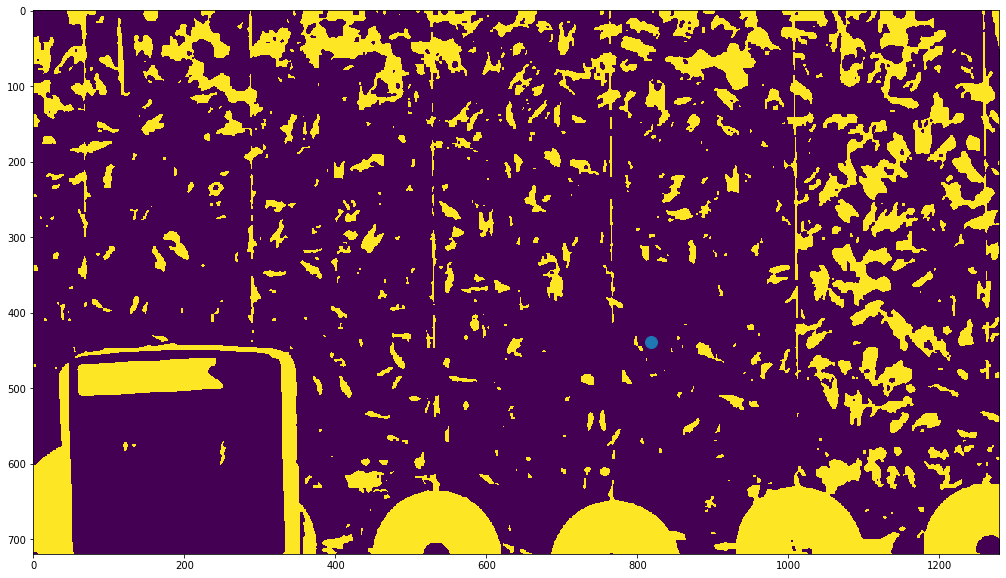

In [19]:
cap.set(1, 71)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
#thresh = cv2.threshold(gray, 130, 220, cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
#opening = cv2.dilate(thresh, kernel, iterations=2)


plt.figure(figsize=(20,10))
plt.imshow(opening)
plt.plot(818, 439, marker='o', markersize=12)

In [20]:
clust[clust['frame']==223]
clust

,index,x,y,frame,size,contour,Cluster
39,39,1213,25,73,250.5,"[[[1194, 10]], [[1194, 11]], [[1194, 12]], [[1...",1
40,40,1217,50,78,294.5,"[[[1216, 21]], [[1216, 22]], [[1217, 23]], [[1...",1
41,41,1221,47,79,404.5,"[[[1214, 8]], [[1214, 9]], [[1214, 10]], [[121...",1
43,43,1222,31,87,325.0,"[[[1222, 0]], [[1222, 1]], [[1222, 2]], [[1222...",1
44,44,1220,33,88,325.0,"[[[1235, 14]], [[1234, 15]], [[1233, 16]], [[1...",1
45,45,1202,35,93,344.0,"[[[1225, 14]], [[1225, 15]], [[1224, 16]], [[1...",1
46,46,1201,35,94,275.0,"[[[1225, 14]], [[1225, 15]], [[1224, 16]], [[1...",1
47,47,1201,31,96,372.5,"[[[1232, 0]], [[1232, 1]], [[1232, 2]], [[1232...",1
48,48,1203,34,97,467.5,"[[[1225, 9]], [[1225, 10]], [[1225, 11]], [[12...",1
49,49,1204,36,98,344.5,"[[[1224, 15]], [[1223, 16]], [[1222, 17]], [[1...",1


In [ ]:
missing = list(set(rang)-set(clust.frame.values))
missing

In [33]:
df[df['Cluster']==72]

,index,x,y,frame,size,contour,Cluster
1966,1966,1145,357,1342,255.5,"[[[1134, 331]], [[1133, 332]], [[1132, 332]], ...",72
1967,1967,1147,376,1348,316.0,"[[[1138, 353]], [[1139, 353]], [[1140, 354]], ...",72
1968,1968,1170,351,1349,283.0,"[[[1156, 334]], [[1155, 335]], [[1154, 335]], ...",72
1969,1969,1151,369,1350,279.5,"[[[1120, 352]], [[1119, 353]], [[1118, 353]], ...",72
1970,1970,1170,367,1354,193.0,"[[[1167, 354]], [[1166, 355]], [[1166, 356]], ...",72
1971,1971,1152,356,1357,321.0,"[[[1152, 311]], [[1152, 312]], [[1152, 313]], ...",72
1972,1972,1146,368,1358,226.0,"[[[1109, 357]], [[1110, 357]], [[1111, 358]], ...",72
1973,1973,1175,362,1358,288.5,"[[[1161, 351]], [[1160, 352]], [[1160, 353]], ...",72
1974,1974,1155,342,1359,199.0,"[[[1157, 307]], [[1156, 308]], [[1155, 308]], ...",72
1975,1975,1149,349,1362,184.5,"[[[1144, 330]], [[1145, 331]], [[1145, 332]], ...",72
